In [1]:
### This one uses a lot of custom matlab code. Might be better
### to write a python tutorial that utilizes toolboxes and common functinos

In [3]:
import scipy.io as si
import numpy as np
import matplotlib.pyplot as plt
import nilearn as ni
import xarray as xr
%matplotlib inline

In [5]:
import numpy as np
from nipy.core.api import Image, vox2mni

In [6]:
## Load the data
data = si.loadmat('../Allie/SfN_materials/Classification/code/fmriDat.mat')

FileNotFoundError: [Errno 2] No such file or directory: '../Allie/SfN_materials/Classification/code/fmriDat.mat'

In [70]:
fmri = data['activity']
ntrial, nvox, ntime = fmri.shape

In [76]:
# Plot the activity 
itrial = 50    # value of trial to plot
iz = 7        # value of z to plot
it = 14        # value of t to plot

In [77]:
import nibabel as nb

In [78]:
from sklearn.preprocessing import scale

In [79]:
meta = data['metaDat'][0, 0][0]
meta = meta - 1

In [80]:
mask_z = meta[:, 2] == iz
fmri_slice = fmri[itrial][mask_z][:, it]
space = np.zeros([meta[:, 0].max(), meta[:, 1].max()])

In [81]:
for ivox, (ix, iy) in zip(fmri_slice, meta[mask_z][:, :2]):
    space[ix, iy] = ivox

IndexError: index 50 is out of bounds for axis 0 with size 50

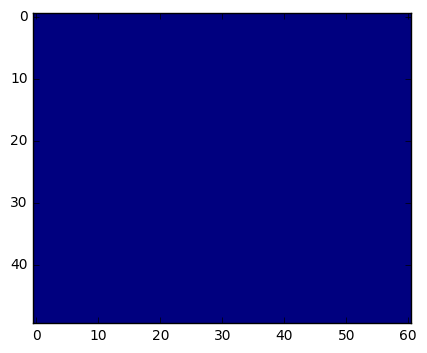

In [59]:
fig, ax = plt.subplots()
ax.imshow(space, vmin)

In [ ]:
## Plotting the data
plotActivity(activity, metaDat, itrial, iz, it)

# Add a colorbar
colorbar()

##
# Now plot the activity from one of the trials where the
# patient was seeing the picture 
itrial = 50  # value of trial to plot
iz = 8         # value of z to plot
itime = 14     # value of t to plot

# Measure the max and min on the snap with in the "task" trial.
# When we plot the rest and task trials together, we can place
# them on the same color scale.
vmax = max(activity(itrial,:,itime))
vmin = min(activity(itrial,:,itime))

subplot(1,2,2)
plotActivity(activity, metaDat, itrial, iz, it, vmin, vmax)
title('Sentence')
set(gca,'FontSize',16)

# Now plot the fMRI from a "sentence" trial
itrial = 10       # value of trial to plot
iz = 8            # value of z to plot
itime = 14        # value of t to plot
subplot(1,2,1)
plotActivity(activity, metaDat, itrial, iz, it, vmin, vmax)
title('Picture')
set(gca,'FontSize',16)

## Exercise 1
# (a) In trial 50, find the average activity in each voxel over time.

# Soln:  Get the activity.  Use the squeeze command to remove the first
# dimension 
itrial = 50
A = squeeze(activity(itrial,:,:))   
    
Amean = mean(A,2)          # Average over second dimension, i.e. time

# (b) Find the voxels with the three largest average activities
[Asort,Isort] = sort(Amean, 'descend')
pos = metaDat.colToCoord(Isort(1:3),:)

# In trial 50, time=40, find the x,y,z locations of the voxels with the
# three largest average activities.  


## Scatter plot for a Single Variable Classifier

# Get a single variable.  We will explain how to select the variable below
itime = 14     # time point within each trial
ivox = 4688   # voxel index within the time

# Get the activity values on the selected voxel
x = activity(:,ivox,itime)

# Get the labels.  Since the labels in the data are 1 and 2,
# we subtract 1 to make the labels y=0 or 1.
y = labels-1

# Go to one subplot
subplot(1,1,1)

# Find samples where y==0 and plot those
I0 = (y==0)
plot(x(I0),y(I0),'o','LineWidth',3)
hold on

# Find samples where y==1 and plot those
I1 = (y==1)
plot(x(I1),y(I1),'x','LineWidth',3)
hold off

# Add grid lines, legend, etc...
grid on
set(gca,'FontSize',16)
legend('Picture','Sentence','Location','NorthWest')
xlabel('Activity')
ylabel('Class')
axis([-15 20 -0.2 1.2])

## Exercise 2
# For the selected voxel activities x, find the 
#    average during a sentence (y==1), 
#    average during a picture (y==0), 
#    standard deviation 
#    normalized shift

# Get indices where y==0 or 1
I0 = (y==0)
I1 = (y==1)

# Find average in each class, the std deviation, and
# normalized shift
xmean0 = mean(x(I0))
xmean1 = mean(x(I1))
xstd = std(x)
zshift = (xmean1-xmean0)/xstd

fprintf(1,'xmean0 = #f, xmean1 = #f\n', xmean0, xmean1)
fprintf(1,'xstd = #f\n', xstd)
fprintf(1,'normalized shift = #f\n', zshift )



## Optimizing the Threshold

# Plot accuracy vs. threshold
tvals = linspace(min(x),max(x),500)
ntvals = length(tvals)
acc = zeros(ntvals,1)
for i = 1:ntvals
    t = tvals(i)
    yhat = (x>t)
    acc(i) = mean( yhat == y )
end
plot(tvals,acc,'-','LineWidth',3)
grid on
xlabel('Threshold')
ylabel('Accuracy')
set(gca,'FontSize',16)

# Find the optimal threshold
[accmax,im] = max(acc)
tmax = tvals(im)
fprintf(1,'Max acc = #7.2f, t=#7.2f\n', accmax, tmax)


## Exercise 3:  
# Modify the above code to plot the FPR and FNR
# for each threshold value.  Plot FPR and FPR vs. t
# Add a legend to your graph

# Plot FPR and FNR vs. threshold
tvals = linspace(min(x),max(x),500)
ntvals = length(tvals)
fpr = zeros(ntvals,1)
fnr = zeros(ntvals,1)
for i = 1:ntvals
    t = tvals(i)
    yhat = (x>t)
    fpr(i) = mean((yhat==1) & (y==0) )
    fnr(i) = mean((yhat==0) & (y==1) )
end
plot(tvals,[fpr fnr],'-','LineWidth',3)
grid on
legend('FPR', 'FNR', 'Location', 'SouthEast')
set(gca,'FontSize',16)
xlabel('Threshold')
ylabel('Error rate')
axis([min(tvals) max(tvals) 0 0.5])



## Finding an activity variable via maximum correlation
# Now, we look at how we can find the activity variable

# Get total number of variables
p = nvox*ntime

# Create data matrix and labels
X = reshape(activity,ntrial,p)
y = labels

# Standardize matrices
Xs = zscore(X)
ys = zscore(y)

# Compute correlation
n = size(Xs,1)
rho = Xs'*ys/n
rhosq = rho.^2

# Find the maximum value
[rhom, im] = max(rhosq(:))
[ivoxm, itm] = ind2sub([nvox ntime],im)

# Plot the correlation across the variables
stem(rhosq)
xlabel('Variable','Fontsize',16)
ylabel('Correlation \rho^2', 'Fontsize',16)
grid on

return


## Adding a Second Variable

# Sort the correlations in descending order
[rhos,Is] = sort(rhosq(:),'descend')
p = 2
Xtot = reshape(activity,ntrial,nvox*ntime)
X = Xtot(:,Is(1:p))

# Plot points
I0 = (y==0)
plot(X(I0,1),X(I0,2),'o','LineWidth',3)
hold on
I1 = (y==1)
plot(X(I1,1),X(I1,2),'x','LineWidth',3)
hold off
grid on
set(gca,'FontSize',16)
legend('Picture','Sentence','Location','NorthWest')
##ylabel('Class')